In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('Data/train.csv')
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
df.loc[0]['text']

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

In [4]:
from io import StringIO
col = ['target', 'text']
df = df[col]
df.tail()

,target,text
7608,1,Two giant cranes holding a bridge collapse int...
7609,1,@aria_ahrary @TheTawniest The out of control w...
7610,1,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611,1,Police investigating after an e-bike collided ...
7612,1,The Latest: More Homes Razed by Northern Calif...


In [5]:
df.columns = ['target', 'text']
target_df = df[['text', 'target']].drop_duplicates().sort_values('target')
target_dict = dict(target_df.values)
df.head()

,target,text
0,1,Our Deeds are the Reason of this #earthquake M...
1,1,Forest fire near La Ronge Sask. Canada
2,1,All residents asked to 'shelter in place' are ...
3,1,"13,000 people receive #wildfires evacuation or..."
4,1,Just got sent this photo from Ruby #Alaska as ...


In [6]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('target').text.count().plot.bar(ylim=0)
plt.show()

<Figure size 800x600 with 1 Axes>

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.text).toarray()
labels = df.target
features.shape

(7613, 3623)

In [8]:
from sklearn.feature_selection import chi2
N = 2
for target in [0,1]:
  features_chi2 = chi2(features, labels == target)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(target))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# '0':
  . Most correlated unigrams:
. hiroshima
. california
  . Most correlated bigrams:
. suicide bombing
. suicide bomber
# '1':
  . Most correlated unigrams:
. hiroshima
. california
  . Most correlated bigrams:
. suicide bombing
. suicide bomber


[1]


C:\Users\JBKec\Anaconda3\envs\opencv\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,id,target
0,0,1
1,2,0
2,3,1
3,9,1
4,11,1


NameError: name 'answerDf' is not defined

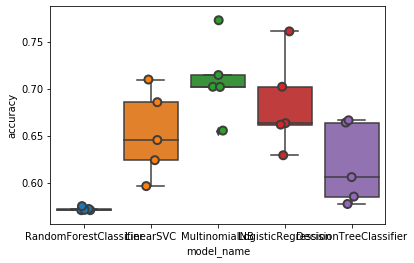

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import cross_val_score

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
    DecisionTreeClassifier()
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()
count_vect = CountVectorizer()
tfidf_transformer = TfidfTransformer()


In [10]:
cv_df.groupby('model_name').accuracy.mean()


model_name
DecisionTreeClassifier    0.619602
LinearSVC                 0.652049
LogisticRegression        0.683312
MultinomialNB             0.709189
RandomForestClassifier    0.571785
Name: accuracy, dtype: float64

In [11]:
test_df = pd.read_csv('Data/test.csv')

In [12]:
trainCounts = count_vect.fit_transform(df['text'])
X_train_tfidf = tfidf_transformer.fit_transform(trainCounts)

In [20]:
for model in models:
    model_name = model.__class__.__name__
    clf = model.fit(X_train_tfidf, labels)
    solution_df = test_df[['id']]
    solution_df['target'] = test_df.apply(lambda row : clf.predict(count_vect.transform([row['text']])), axis = 1)
    solution_df['target'] = solution_df.apply(lambda row : row['target'][0], axis=1)
    solution_df.to_csv('Data/preds_'+model_name +'.csv', index= False)

C:\Users\JBKec\Anaconda3\envs\opencv\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\JBKec\Anaconda3\envs\opencv\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\JBKec\Anaconda3\envs\opencv\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum